In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

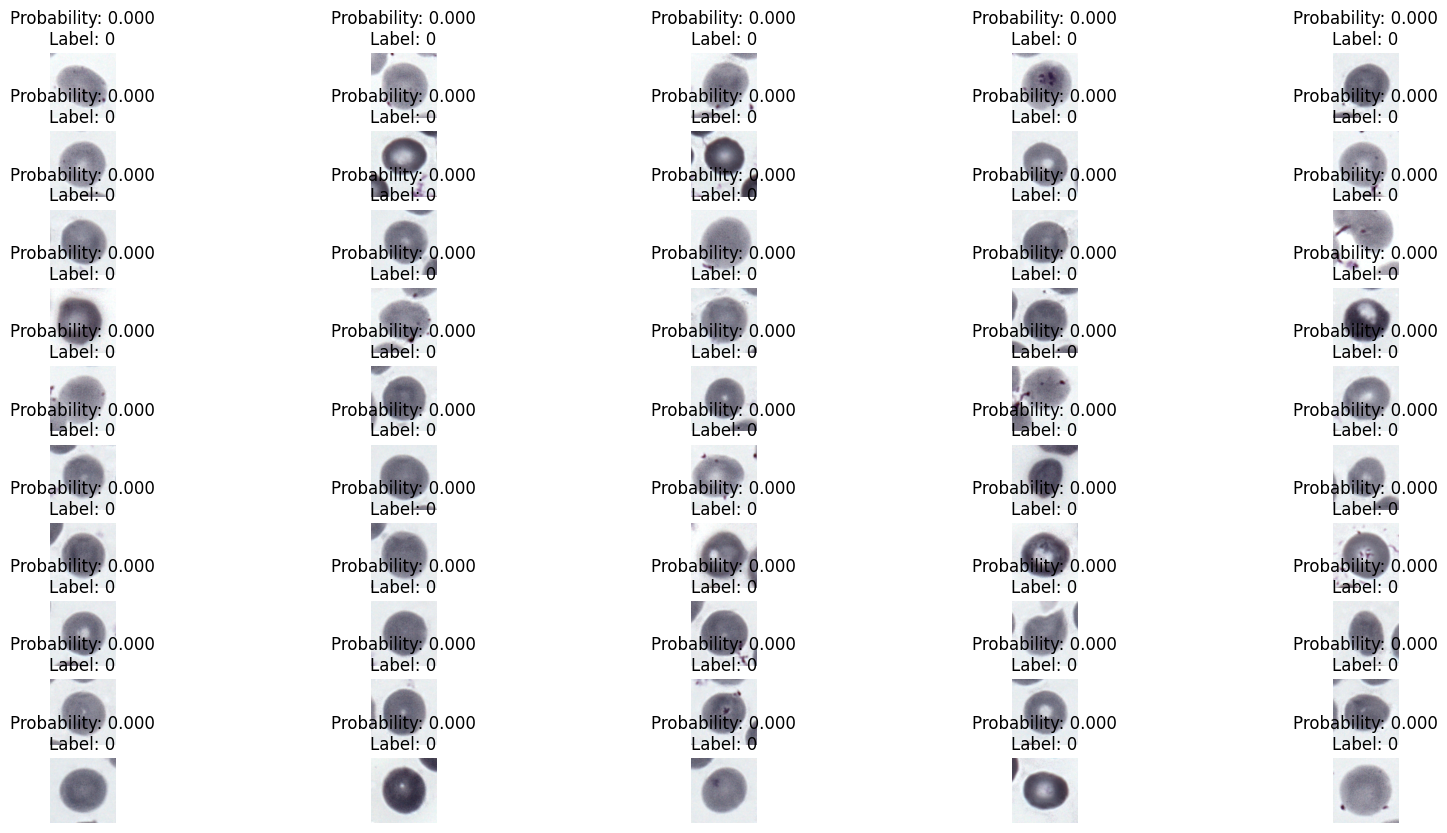

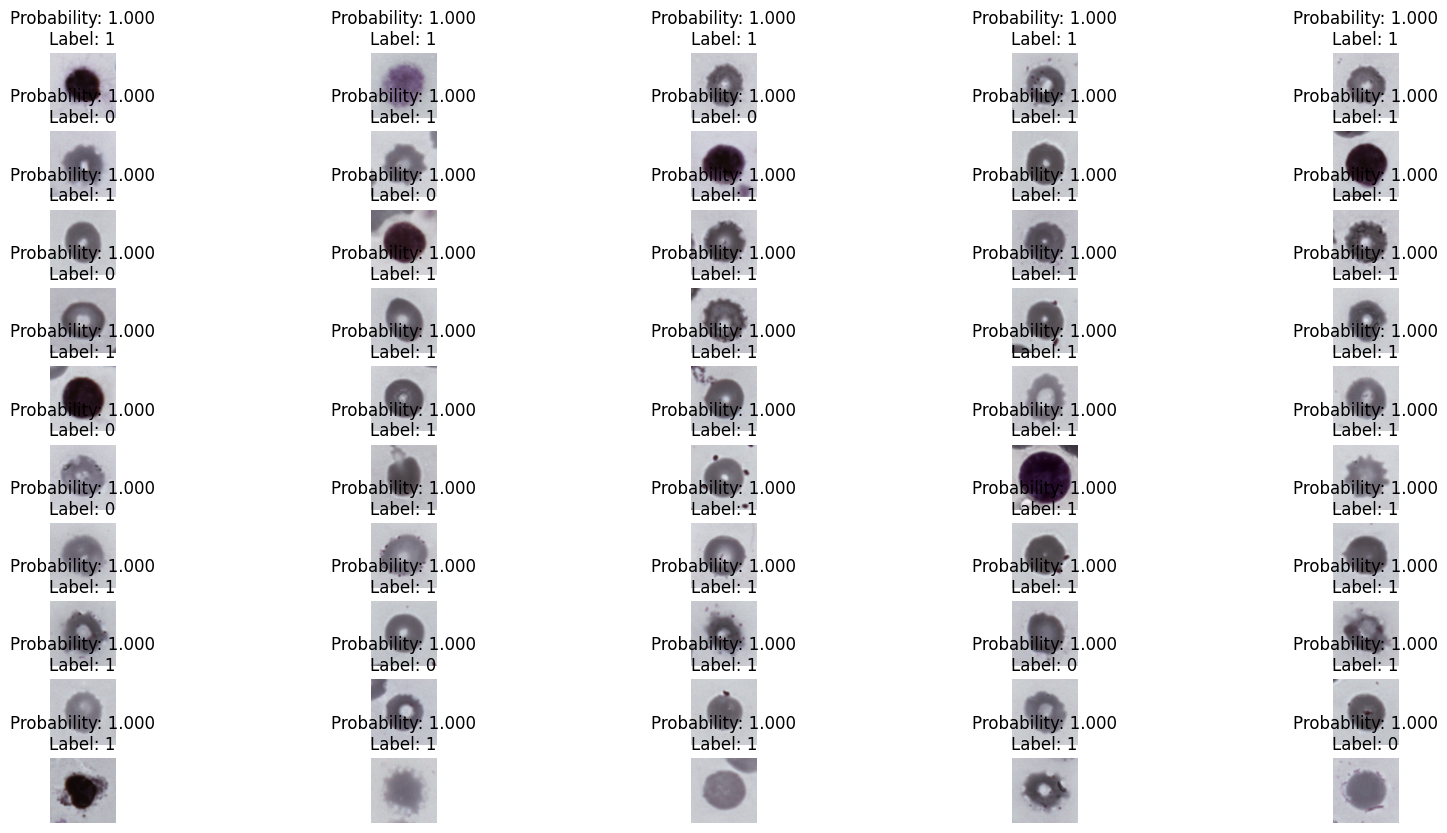

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Read the CSV dataframe
df = pd.read_csv('classified_cells_pca.csv')

# Sort the dataframe by predicted probability in ascending order
df_sorted_asc = df.sort_values(by=['predicted_probability'], ascending=True)

# Get the 50 images with lowest probability
low_prob_images = df_sorted_asc[:50]['image_path'].tolist()
low_prob_probs = df_sorted_asc[:50]['predicted_probability'].tolist()
low_prob_labels = df_sorted_asc[:50]['true_label'].tolist()

# Sort the dataframe by predicted probability in descending order
df_sorted_desc = df.sort_values(by=['predicted_probability'], ascending=False)

# Get the 50 images with highest probability
high_prob_images = df_sorted_desc[:50]['image_path'].tolist()
high_prob_probs = df_sorted_desc[:50]['predicted_probability'].tolist()
high_prob_labels = df_sorted_desc[:50]['true_label'].tolist()

# Plot the images with lowest probability
fig, axs = plt.subplots(10, 5, figsize=(20, 10))

for i in range(50):
    image = Image.open(low_prob_images[i])
    axs[i//5, i%5].imshow(image)
    axs[i//5, i%5].set_title(f'Probability: {low_prob_probs[i]:.3f}\nLabel: {low_prob_labels[i]}')
    axs[i//5, i%5].axis('off')

# Plot the images with highest probability
fig2, axs2 = plt.subplots(10, 5, figsize=(20, 10))

for i in range(50):
    image = Image.open(high_prob_images[i])
    axs2[i//5, i%5].imshow(image)
    axs2[i//5, i%5].set_title(f'Probability: {high_prob_probs[i]:.3f}\nLabel: {high_prob_labels[i]}')
    axs2[i//5, i%5].axis('off')

# Show the plots
plt.show()


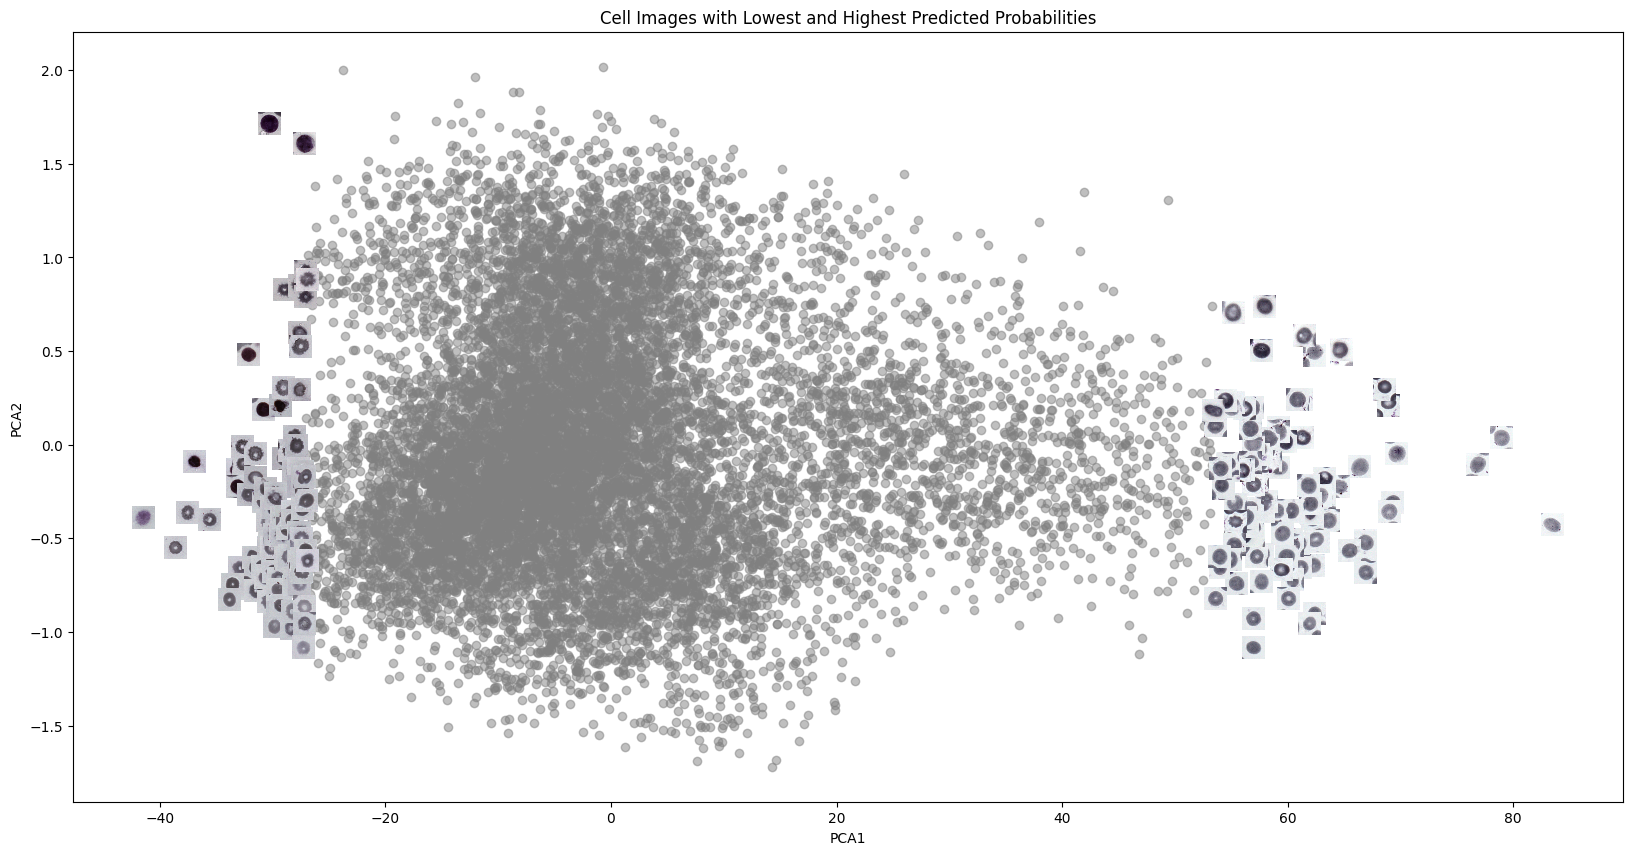

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

# Function to plot images on the PCA scatter plot
def imscatter(x, y, image_paths, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, path in zip(x, y, image_paths):
        try:
            img = Image.open(path)
            image = OffsetImage(img, zoom=zoom)
            ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        except IOError:
            print(f"Error opening image at {path}.")
    return artists

# Load the dataframe
df = pd.read_csv('classified_cells_pca.csv')

# Sort by predicted_probability in ascending order and select the lowest 50
lowest_50 = df.nsmallest(100, 'predicted_probability')

# Sort by predicted_probability in descending order and select the highest 50
highest_50 = df.nlargest(100, 'predicted_probability')

# Combine both subsets into one dataframe for plotting
combined_df = pd.concat([lowest_50, highest_50])

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))

# Plot all the points as scatter plot
ax.scatter(df['PCA1'], df['PCA2'], c='gray', alpha=0.5)

# Highlight the 50 lowest probabilities in blue
imscatter(lowest_50['PCA1'], lowest_50['PCA2'], lowest_50['image_path'], ax=ax, zoom=0.1)

# Highlight the 50 highest probabilities in red
imscatter(highest_50['PCA1'], highest_50['PCA2'], highest_50['image_path'], ax=ax, zoom=0.1)

# Additional plot formatting
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('Cell Images with Lowest and Highest Predicted Probabilities')
plt.show()


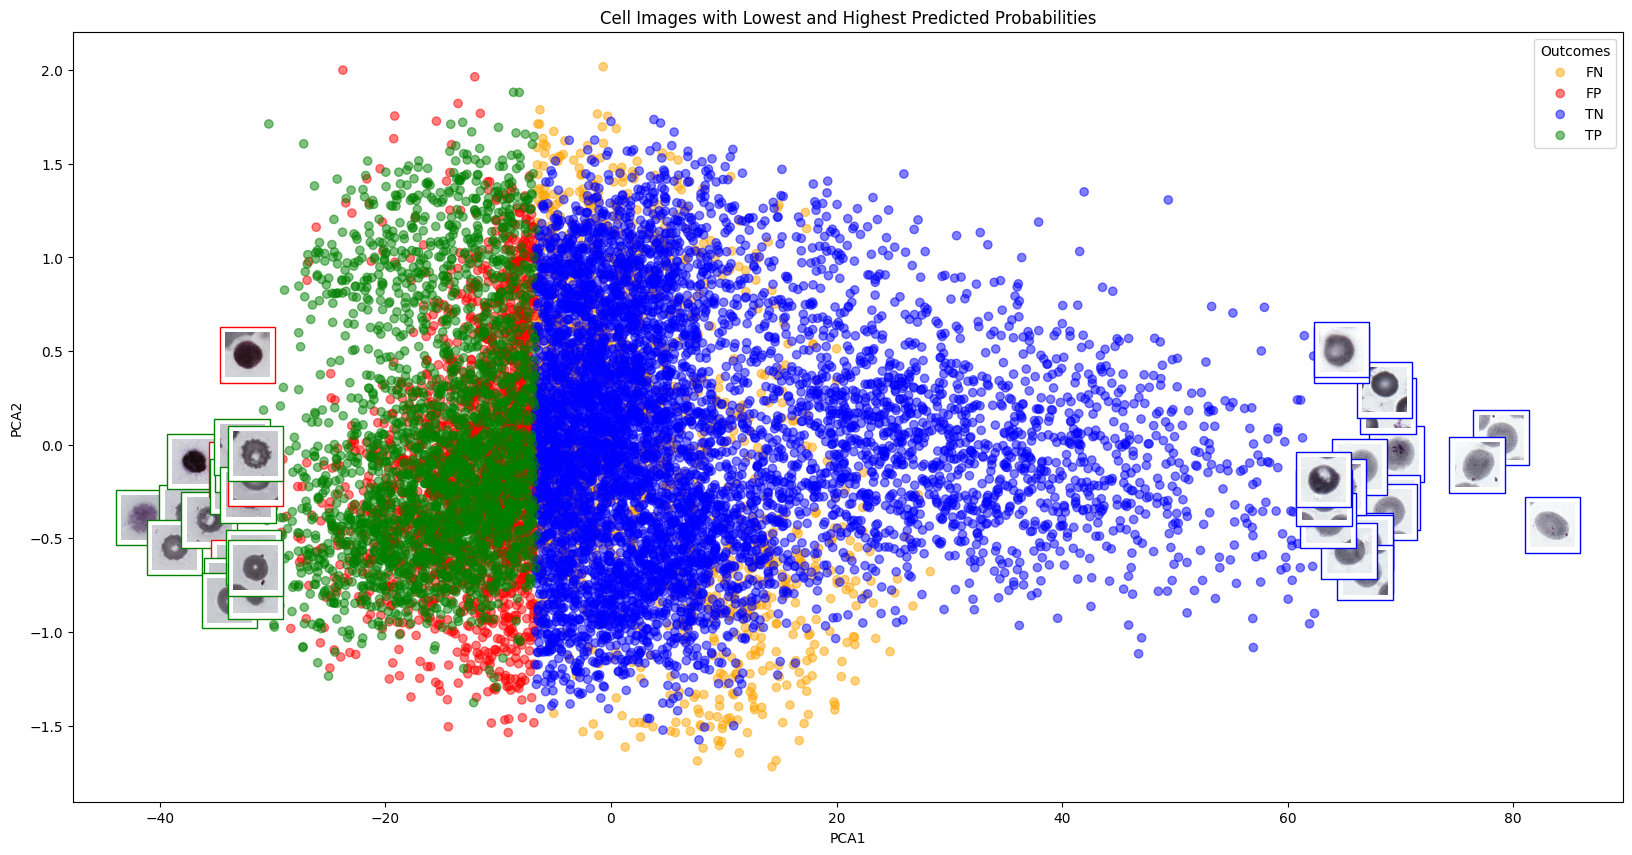

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image

# Function to plot images on the PCA scatter plot
def imscatter(x, y, image_paths, ax=None, zoom=1, colors=None):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, path, color in zip(x, y, image_paths, colors):
        try:
            img = Image.open(path)
            image = OffsetImage(img, zoom=zoom)
            ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=True, 
                                bboxprops=dict(edgecolor=color))
            artists.append(ax.add_artist(ab))
        except IOError:
            print(f"Error opening image at {path}.")
    return artists

# Load the dataframe
df = pd.read_csv('classified_cells_pca.csv')

# Assuming that the threshold for binary classification is 0.5
df['predicted_label'] = df['predicted_probability'] >= 0.5

# Define TP, TN, FP, FN
df['outcome'] = np.where((df['true_label'] == df['predicted_label']) & (df['predicted_label'] == 1), 'TP',
               np.where((df['true_label'] == df['predicted_label']) & (df['predicted_label'] == 0), 'TN',
               np.where((df['true_label'] != df['predicted_label']) & (df['predicted_label'] == 1), 'FP', 'FN')))

# Color mapping for outcomes
color_map = {'TP': 'green', 'TN': 'blue', 'FP': 'red', 'FN': 'orange'}

# Apply color mapping
df['color'] = df['outcome'].map(color_map)

# Sort by predicted_probability in ascending order and select the lowest 50
lowest_50 = df.nsmallest(20, 'predicted_probability')

# Sort by predicted_probability in descending order and select the highest 50
highest_50 = df.nlargest(20, 'predicted_probability')

# Combine both subsets into one dataframe for plotting
combined_df = pd.concat([lowest_50, highest_50])

# Plotting
fig, ax = plt.subplots(figsize=(20, 10))

# Plot all the points as scatter plot
for outcome, group in df.groupby('outcome'):
    ax.scatter(group['PCA1'], group['PCA2'], c=group['color'], label=outcome, alpha=0.5)

# Highlight the 50 lowest probabilities with images
imscatter(lowest_50['PCA1'], lowest_50['PCA2'], lowest_50['image_path'], ax=ax, zoom=0.2, colors=lowest_50['color'])

# Highlight the 50 highest probabilities with images
imscatter(highest_50['PCA1'], highest_50['PCA2'], highest_50['image_path'], ax=ax, zoom=0.2, colors=highest_50['color'])

# Additional plot formatting
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.legend(title='Outcomes')
ax.set_title('Cell Images with Lowest and Highest Predicted Probabilities')
plt.show()


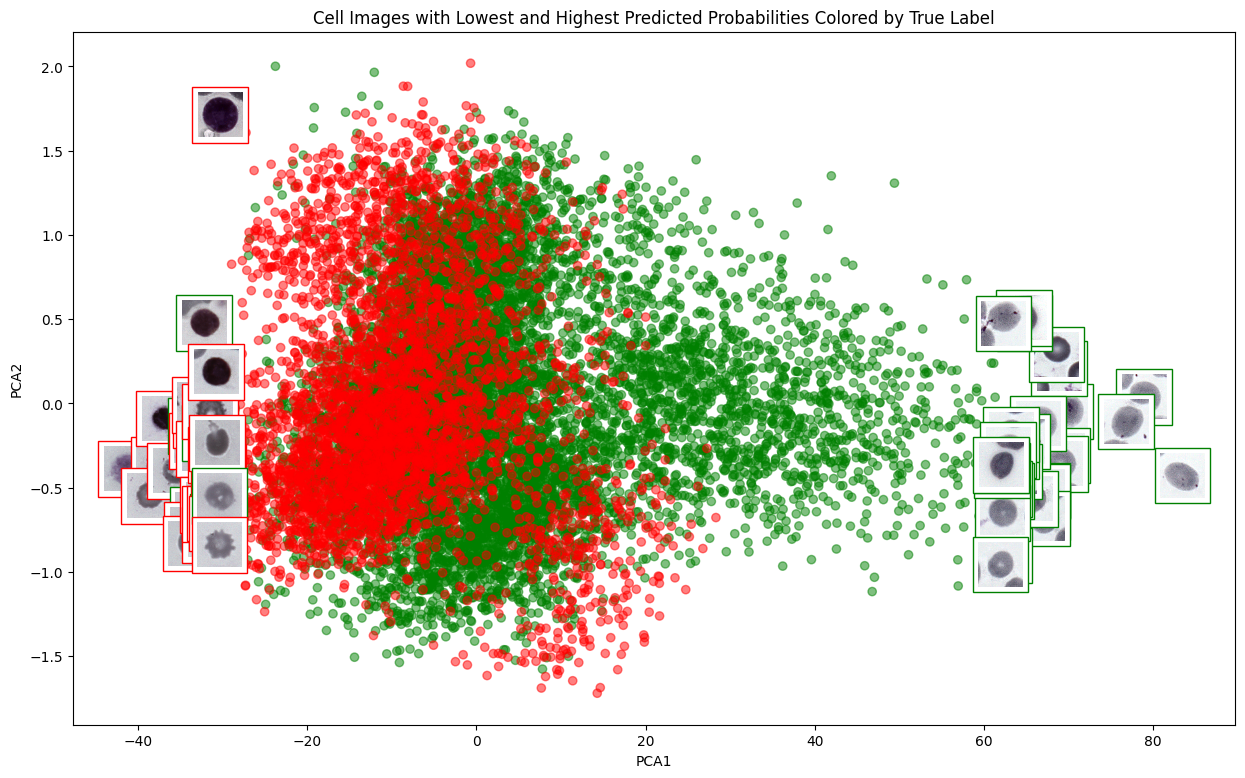

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from PIL import Image
from matplotlib.patches import FancyArrowPatch

# Function to plot images on the PCA scatter plot
def imscatter(x, y, image_paths, ax=None, zoom=1, colors=None):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, path, color in zip(x, y, image_paths, colors):
        try:
            img = Image.open(path).convert("RGBA")
            image = OffsetImage(img, zoom=zoom)
            ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=True,
                                bboxprops=dict(edgecolor=color))
            artists.append(ax.add_artist(ab))
        except IOError:
            print(f"Error opening image at {path}.")
    return artists

# Load the dataframe
df = pd.read_csv('classified_cells_pca.csv')

# Color mapping for true_label
color_map = {0: 'green', 1: 'red'}  # Adjust colors as needed

# Apply color mapping
df['color'] = df['true_label'].map(color_map)

# Sort by predicted_probability in ascending order and select the lowest 50
lowest_50 = df.nsmallest(30, 'predicted_probability')

# Sort by predicted_probability in descending order and select the highest 50
highest_50 = df.nlargest(30, 'predicted_probability')

# Plotting
fig, ax = plt.subplots(figsize=(15, 9))

# Plot all the points as scatter plot with colors based on true_label
ax.scatter(df['PCA1'], df['PCA2'], c=df['color'], alpha=0.5)

# Highlight the 50 lowest probabilities with images
imscatter(lowest_50['PCA1'], lowest_50['PCA2'], lowest_50['image_path'], ax=ax, zoom=0.2, colors=lowest_50['color'])

# Highlight the 50 highest probabilities with images
imscatter(highest_50['PCA1'], highest_50['PCA2'], highest_50['image_path'], ax=ax, zoom=0.2, colors=highest_50['color'])

# Additional plot formatting
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('Cell Images with Lowest and Highest Predicted Probabilities Colored by True Label')
plt.show()
